In [196]:
# import important libraries
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras import ops
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import r2_score

### **Data Generation**

In [197]:
### projectile motion equations

### Horizontal motion equations for the projectile
### x_f = x_i + v_x * delta_t
### v_fx = v_ix
### v_fy = v_iy + a_y * delta_t
### y_f = y_i + v_iy * t - 1/2 * g * delta_t**2
### v_fy**2 = v_iy**2 - 2*g*(y_f - y_i)

# Generating Mock Data for Training Data

# number of mock points
num_points = 10**6;

g = 9.81; # gravity

x_i = 0; # by convention of coordinate system
y_i = 0; # by convention of coordinate system

def generate_data(num_samples):
    theta = np.random.uniform(0, np.pi/2, num_samples)  # Only 0-90° makes physical sense
    v_i = np.random.uniform(0, 80, num_samples)  # 0-80 mph
    R = (v_i**2 * np.sin(2*theta)) / g  # Range calculation
    return np.column_stack([v_i, theta]), R  # Features and labels


In [198]:
x_train, y_train = generate_data(10**6)
x_test, y_test = generate_data(10**5)

In [199]:
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)

### **Neural Network**

In [200]:
x_train = np.load('x_train.npy', allow_pickle = True)
y_train = np.load('y_train.npy', allow_pickle = True)
x_test = np.load('x_test.npy', allow_pickle = True)
y_test = np.load('y_test.npy', allow_pickle = True)

In [201]:
print(x_train, y_train)
print(x_test,y_test)

[[50.3297882   1.45822857]
 [79.11201866  0.6778619 ]
 [36.92198995  1.44049503]
 ...
 [51.68310279  0.30815297]
 [17.90997249  0.33486012]
 [18.51220845  1.30956703]] [ 57.64348168 623.29424464  35.80576757 ... 157.38905651  20.29781219
  17.43245916]
[[32.26901543  1.0654255 ]
 [46.02506049  1.31516248]
 [25.93529206  1.08877887]
 ...
 [65.83645206  1.00890239]
 [49.61292912  1.1821375 ]
 [ 5.55207762  1.40021999]] [ 89.92940707 105.65256604  56.32747963 ... 398.42559815 175.98185989
   1.05131695]


In [202]:
# Normalize data
v_mean, v_std = x_train[:,0].mean(), x_train[:,0].std()
theta_mean, theta_std = x_train[:,1].mean(), x_train[:,1].std()

x_train[:,0] = (x_train[:,0] - v_mean) / v_std
x_train[:,1] = (x_train[:,1] - theta_mean) / theta_std
x_test[:,0] = (x_test[:,0] - v_mean) / v_std
x_test[:,1] = (x_test[:,1] - theta_mean) / theta_std


In [203]:
# Model for regression
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    # Simple dense network works better for this
    x = keras.layers.Dense(64, activation='relu')(input_layer)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dense(64, activation='relu')(x)

    # Single output for regression (no activation)
    output_layer = keras.layers.Dense(1)(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [204]:
# Input shape is (2,) for [v_i, theta]
model = make_model(input_shape=(2,))

In [205]:
model.compile(
    optimizer='adam',
    loss='mse',  # Mean squared error for regression
    metrics=['mae']  # Mean absolute error
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 25s 785us/step - loss: 1281.1669 - mae: 9.5119 - val_loss: 0.6325 - val_mae: 0.6180
Epoch 2/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 25s 808us/step - loss: 1.0050 - mae: 0.6214 - val_loss: 0.1384 - val_mae: 0.2817
Epoch 3/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 24s 769us/step - loss: 0.9253 - mae: 0.5561 - val_loss: 0.0904 - val_mae: 0.2343
Epoch 4/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 24s 762us/step - loss: 0.8586 - mae: 0.5341 - val_loss: 0.1830 - val_mae: 0.3075
Epoch 5/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 24s 767us/step - loss: 0.7500 - mae: 0.5188 - val_loss: 0.1984 - val_mae: 0.3023
Epoch 6/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 28s 904us/step - loss: 0.6396 - mae: 0.4701 - val_loss: 0.0868 - val_mae: 0.2259
Epoch 7/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 27s 862us/step - loss: 0.6503 - mae: 0.4603 - val_loss: 0.3121 - val_mae: 0.3980
Epoch 8/10
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 24s 763us/step - loss: 0.6150 - mae: 0.4604 - val_loss: 0.0731 - val_mae: 0.20

### Training Performance Visualization

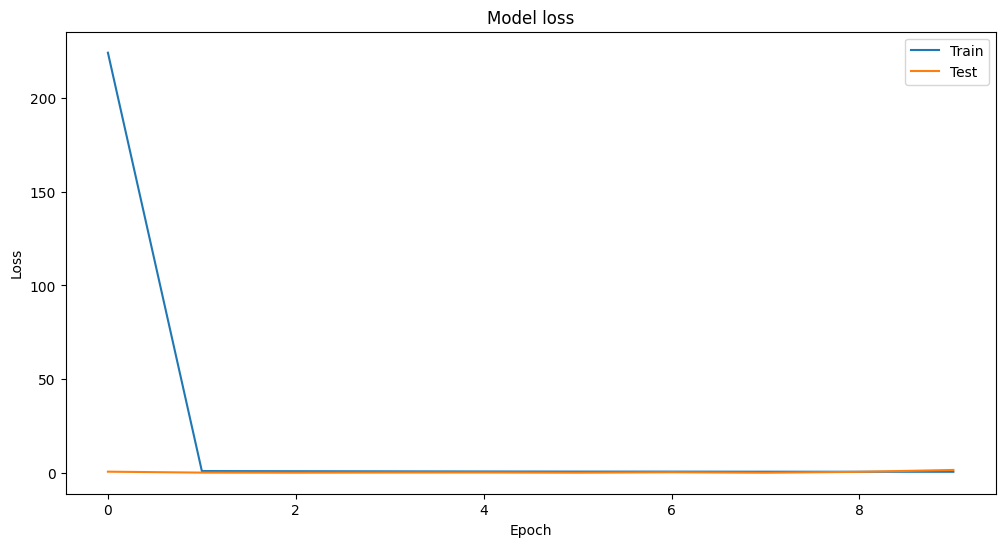

In [206]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig("training_performance.jpg", dpi=300) # Saves as JPG with 300 DPI
plt.show()
plt.close() # Close the plot to free memory

### Prediction vs Actual Comparison

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step


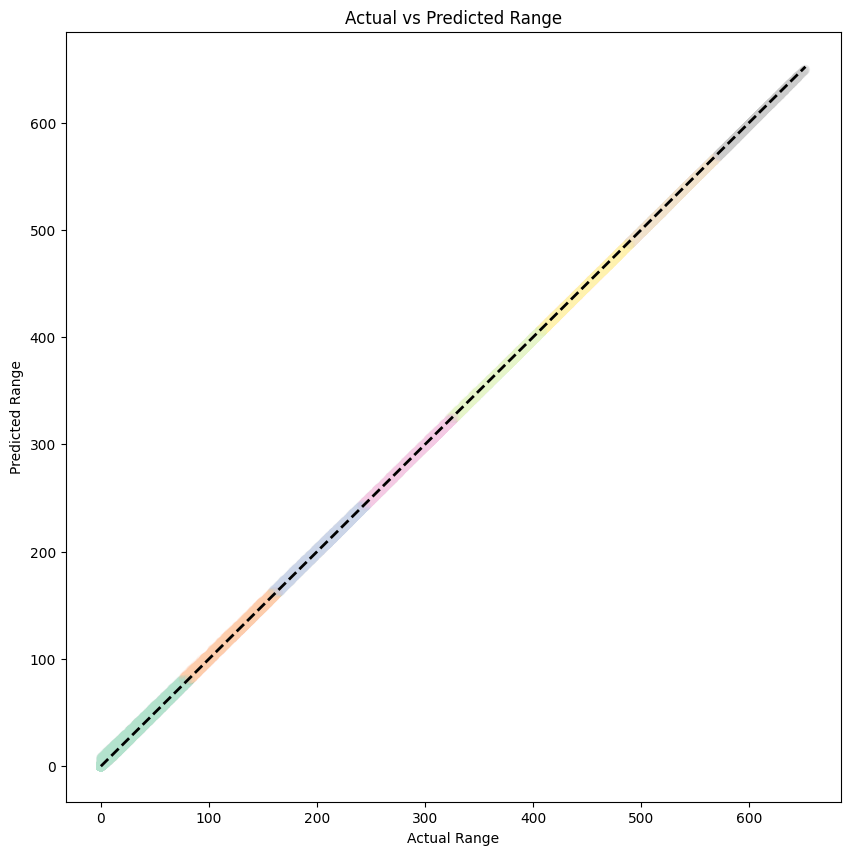

In [207]:
# Get predictions on test set
y_pred = model.predict(x_test)


# Plot predictions vs actual
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, c=y_pred, alpha=0.1, cmap='Pastel2')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.xlabel('Actual Range')
plt.ylabel('Predicted Range')
plt.title('Actual vs Predicted Range')


plt.savefig("prediction_vs_actual.jpg", dpi=300) # Saves as JPG with 300 DPI
plt.show()
plt.close() # Close the plot to free memory

In [208]:
# Get predictions
y_pred = model.predict(x_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_pred.flatten() - y_test))

print("\nModel Performance Metrics:")
print(f"R² Score: {r2:.6f}")
print(f"Mean Absolute Error: {mae:.2f} meters")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 431us/step

Model Performance Metrics:
R² Score: 0.999933
Mean Absolute Error: 0.86 meters


### Error Distribution Analysis

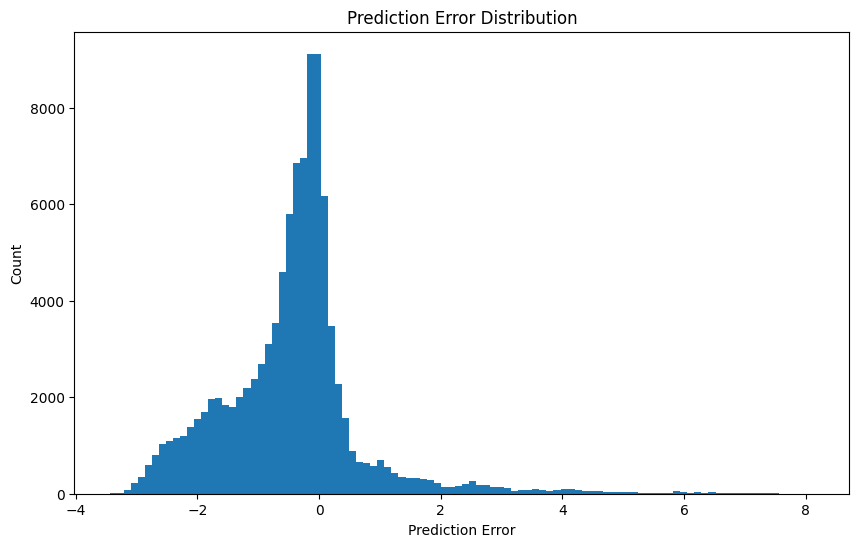

In [209]:
# Calculate errors
errors = y_pred.flatten() - y_test

# Plot error histogram
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=100)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution')
plt.savefig("error_distribution.jpg", dpi=300) # Saves as JPG with 300 DPI
plt.show()
plt.close() # Close the plot to free memory

In [210]:
# Get model predictions
y_pred = model.predict(x_test).flatten()  # Flatten to 1D array

# Calculate residuals (errors)
errors = y_test - y_pred

# Mean error
mean_error = np.mean(errors)
print(f"Mean Error: {mean_error:.4f} meters")

# Standard deviation of errors
error_std = np.std(errors)
print(f"Standard deviation of errors: {error_std:.2f} meters")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step
Mean Error: 0.4393 meters
Standard deviation of errors: 1.16 meters


### 3D Surface Plots of Predictions vs Physics

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


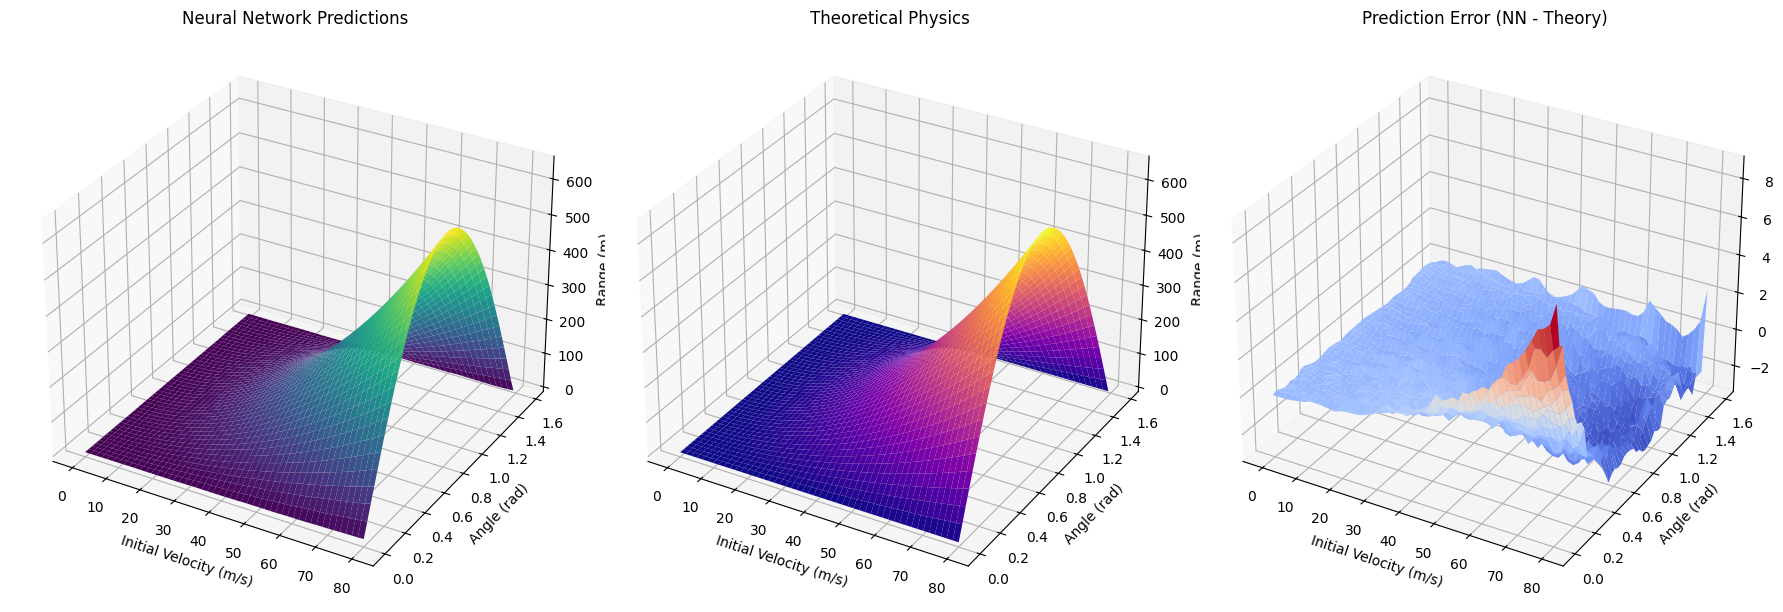

In [215]:
# Create grid for visualization
v_values = np.linspace(0, 80, 50)
theta_values = np.linspace(0, np.pi/2, 50)
V, Theta = np.meshgrid(v_values, theta_values)

# Normalize using same parameters as training
V_norm = (V - v_mean) / v_std
Theta_norm = (Theta - theta_mean) / theta_std

# Predict and reshape
grid_points = np.column_stack([V_norm.ravel(), Theta_norm.ravel()])
R_pred = model.predict(grid_points).reshape(V.shape)

# Calculate theoretical range
R_theory = (V**2 * np.sin(2*Theta)) / g

# Create 3D plots
fig = plt.figure(figsize=(18, 6))

# Predicted surface
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(V, Theta, R_pred, cmap='viridis')
ax1.set_title('Neural Network Predictions')
ax1.set_xlabel('Initial Velocity (m/s)')
ax1.set_ylabel('Angle (rad)')
ax1.set_zlabel('Range (m)')

# Theoretical surface
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(V, Theta, R_theory, cmap='plasma')
ax2.set_title('Theoretical Physics')
ax2.set_xlabel('Initial Velocity (m/s)')
ax2.set_ylabel('Angle (rad)')
ax2.set_zlabel('Range (m)')

# Error surface
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(V, Theta, R_pred - R_theory, cmap='coolwarm')
ax3.set_title('Prediction Error (NN - Theory)')
ax3.set_xlabel('Initial Velocity (m/s)')
ax3.set_ylabel('Angle (rad)')
ax3.set_zlabel('Error (m)')

plt.tight_layout()

plt.savefig("3Dgraph.jpg", dpi=300) # Saves as JPG with 300 DPI

plt.show()

### Contour Plots for Error Analysis

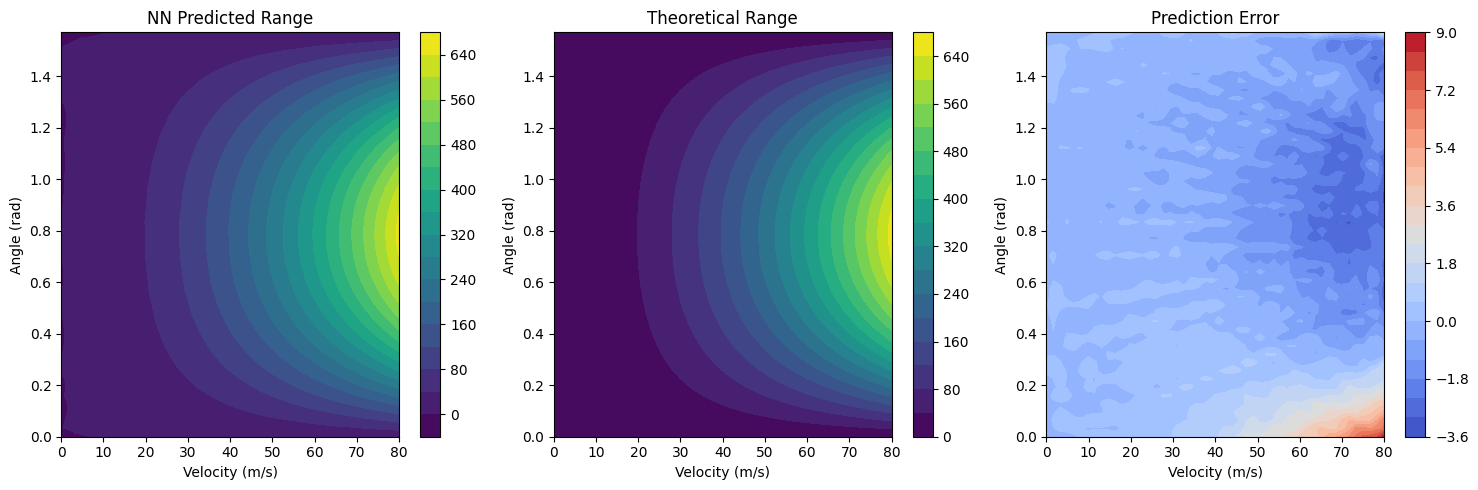

In [212]:
plt.figure(figsize=(15, 5))

# Predicted contours
plt.subplot(131)
plt.contourf(V, Theta, R_pred, 20, cmap='viridis')
plt.colorbar()
plt.title('NN Predicted Range')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Angle (rad)')

# Theoretical contours
plt.subplot(132)
plt.contourf(V, Theta, R_theory, 20, cmap='viridis')
plt.colorbar()
plt.title('Theoretical Range')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Angle (rad)')

# Error contours
plt.subplot(133)
contour = plt.contourf(V, Theta, R_pred - R_theory, 20, cmap='coolwarm')
plt.colorbar(contour)
plt.title('Prediction Error')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Angle (rad)')

plt.tight_layout()
plt.savefig("contours.jpg", dpi=300) # Saves as JPG with 300 DPI
plt.show()
plt.close() # Close the plot to free memory

### Slice Analysis

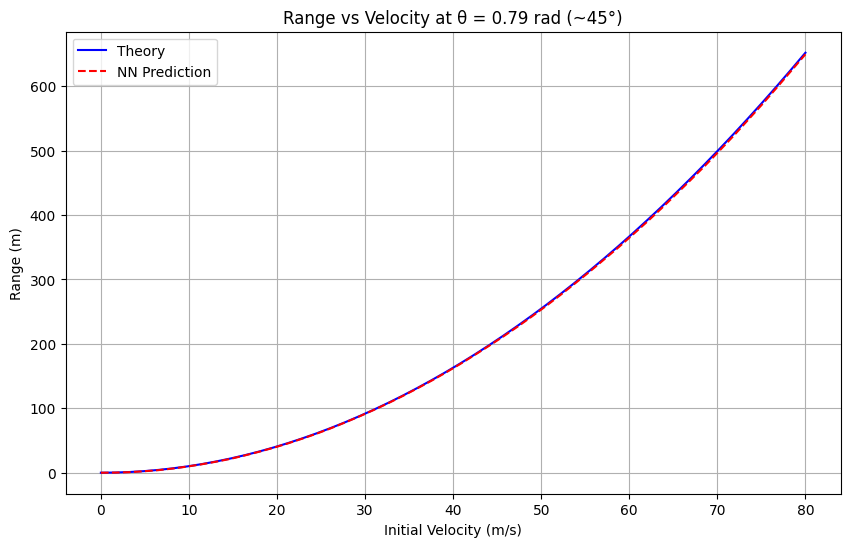

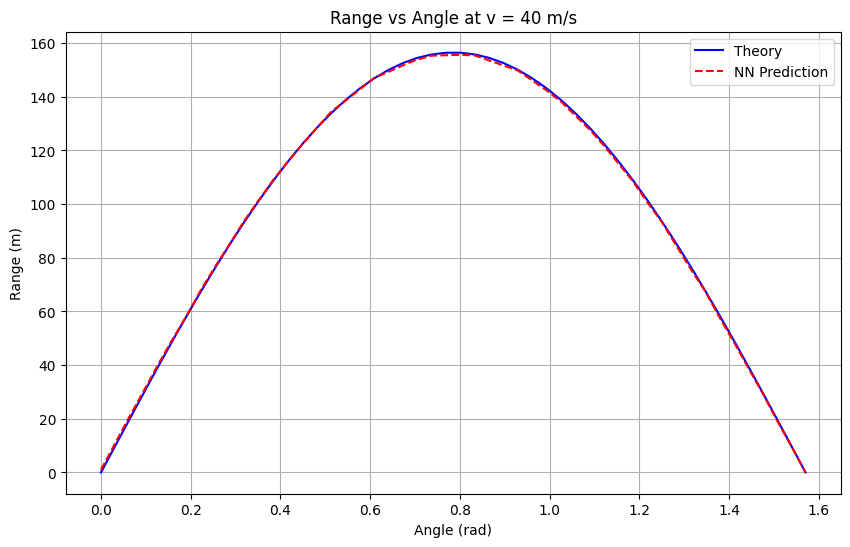

In [213]:
# Fixed angle analysis
fixed_angle = np.pi/4  # 45 degrees
angle_idx = np.argmin(np.abs(theta_values - fixed_angle))

plt.figure(figsize=(10, 6))
plt.plot(v_values, R_theory[angle_idx, :], 'b-', label='Theory')
plt.plot(v_values, R_pred[angle_idx, :], 'r--', label='NN Prediction')
plt.xlabel('Initial Velocity (m/s)')
plt.ylabel('Range (m)')
plt.title(f'Range vs Velocity at θ = {fixed_angle:.2f} rad (~{np.degrees(fixed_angle):.0f}°)')
plt.legend()
plt.grid()
plt.savefig("range_vs_velocity.jpg", dpi=300) # Saves as JPG with 300 DPI
plt.show()
plt.close() # Close the plot to free memory

# Fixed velocity analysis
fixed_velocity = 40  # m/s
vel_idx = np.argmin(np.abs(v_values - fixed_velocity))

plt.figure(figsize=(10, 6))
plt.plot(theta_values, R_theory[:, vel_idx], 'b-', label='Theory')
plt.plot(theta_values, R_pred[:, vel_idx], 'r--', label='NN Prediction')
plt.xlabel('Angle (rad)')
plt.ylabel('Range (m)')
plt.title(f'Range vs Angle at v = {fixed_velocity} m/s')
plt.legend()
plt.grid()

plt.savefig("range_vs_angle.jpg", dpi=300) # Saves as JPG with 300 DPI
plt.show()
plt.close() # Close the plot to free memory